# drifting context branch

In [414]:
import numpy as np
import tensorflow as tf

from pureEM import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## training

In [492]:
def train_loop(net,task,epochs):
  context_emat = np.identity(net.ntrials)
#   context_emat = np.random.randn(net.ntrials,net.context_edim)
  print('\n-context emat')
  print(context_emat)
  # arrays
  L = -1*np.ones(epochs)
  A = -1*np.ones(epochs)
  for ep in range(epochs): 
    T,X,Y = task.gen_episode_data()
    feed_dict = {
      net.trial_ph:T,
      net.stim_ph:X,
      net.y_ph:Y,
      net.context_emat_ph:context_emat
    }
    ops = [
      net.minimizer,
      net.train_loss,
      net.response,
    ]
    # record loss and accuracy
    outs = net.sess.run(ops,feed_dict)
    _,loss,yhat = outs

    L[ep] = loss.mean()
    A[ep] = np.mean(yhat==Y[:,2:])
  return L,A


In [509]:
ntrials = 5
nstim = 5
epochs = 20000

dim = 20

stim_edim = 5
context_edim = ntrials

discount_rate = .9
memory_temp = 4

net = PureEM(nstim,ntrials,dim,stim_edim,context_edim,discount_rate,memory_temp)
task = NBackTask(nstim=nstim,ntrials=ntrials,flip_pr=.5)
L,A = train_loop(net,task,epochs)

gU init, notrain
no inproj, relus
-- proportion of true trials: M=0.37 S=0.17

-context emat
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


Text(0.5,1,'context not trainable')

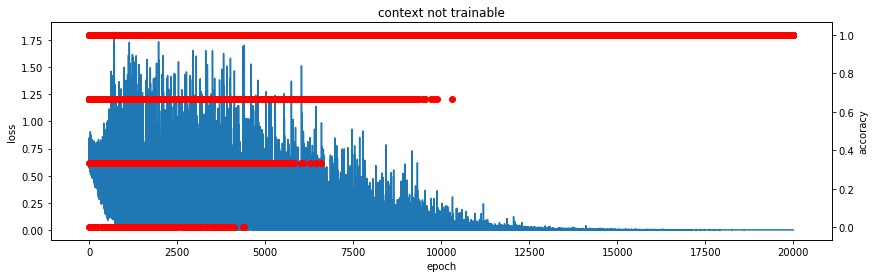

In [510]:
plt.figure(figsize=(14,4))
ax = plt.gca()
ax.plot(L)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax2 = ax.twinx()
ax2.scatter(range(len(A)),A,c='r')
ax2.set_ylabel('accoracy')
plt.title('context not trainable')
# plt.savefig('figures/pureem-shifting_context/train_lossacc-trainable_context')


### inspect learned stim_emat

(5, 5)


array([[ 1.  ,  0.14,  0.13,  0.4 ,  0.01],
       [ 0.14,  1.  , -0.18, -0.53, -0.02],
       [ 0.13, -0.18,  1.  , -0.51, -0.02],
       [ 0.4 , -0.53, -0.51,  1.  , -0.05],
       [ 0.01, -0.02, -0.02, -0.05,  1.  ]])

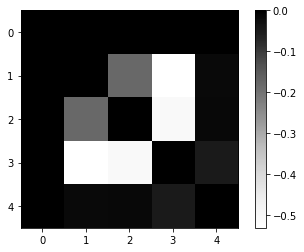

In [511]:
semat = net.sess.run(net.stim_emat)
print(semat.shape)
C = np.corrcoef(semat)
plt.imshow(C,cmap=plt.get_cmap('Greys'),vmax=0)
plt.colorbar()
C.round(2)

### inspect retrieval

Text(0.5,1,'[0, 1, 0, 2, 0]')

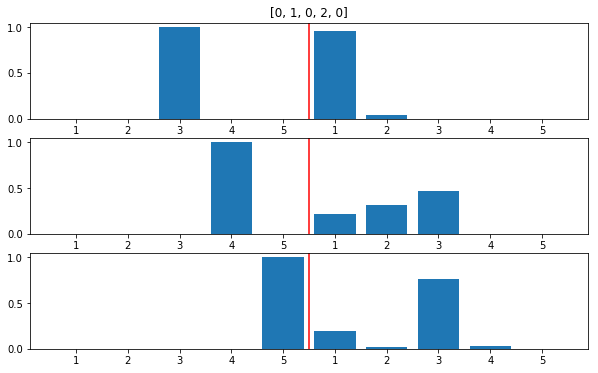

In [513]:
# ntrials = 5
# # context_edim = ntrials
# discount_rate = .9
# memory_temp = 3

# net = PureEM(nstim,ntrials,dim,stim_edim,context_edim,discount_rate,memory_temp)

seq = [0,1,0,2,0]
T,X,Y = task.format_seq_into_dataset(seq)
context_emat = np.identity(ntrials)

feed_dict = {
  net.trial_ph:T,
  net.stim_ph:X,
  net.y_ph:Y,
  net.context_emat_ph:context_emat
}

ops = [
  *net.respinL,
]

respinL = net.sess.run(ops,feed_dict)
fig,axarr = plt.subplots(len(respinL),1,figsize=(10,6),sharex=False);axarr=axarr.reshape(-1)
for t,respin in enumerate(respinL):
  ax = axarr[t]
  ax.bar(np.arange(context_edim*2),respin)
  ax.axvline(ntrials-.5,c='r')
  ax.set_xticks(np.arange(ntrials*2))
  ax.set_xticklabels(np.concatenate([np.arange(ntrials)+1,np.arange(ntrials)+1]))
axarr[0].set_title(seq)

### simulating chance

proportion of true trials: M=0.39 S=0.14


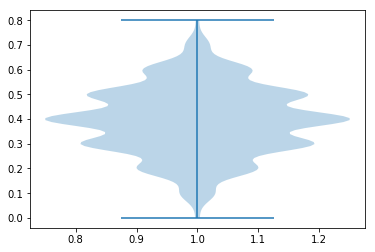

In [749]:
ntrials = 10
nstim = 5
true_nback_pr = .35
task = NBackTask(nstim=nstim,ntrials=ntrials,true_nback_pr=true_nback_pr)

L = []
for i in range(1000):
  T,X,Y = task.gen_episode()
  L.append(Y.sum()/Y.shape[1])

plt.violinplot(L)
print("proportion of true trials: M=%.2f S=%.2f"%(np.mean(L),np.std(L)))

### debugging

In [679]:
ntrials=5
net = PureEM(ntrials=ntrials,dim=2)
# task = NBackTask()
# net.reinitialize()
ntrials=5
for ep in range(1): 
  T,X,Y = task.genseq(ntrials=ntrials)
  feed_dict = {net.trial_ph:T,net.stim_ph:X,net.y_ph:Y}
  ops = [
    net.M_keys,
    net.query_key_sim,
    net.stim,
    net.retrieved_memory,
    net.M_values,
    net.context,
    net.response_in
  ]
  outs = net.sess.run(ops,feed_dict)

Tensor("strided_slice_2:0", shape=(1, 2), dtype=float32)
Tensor("strided_slice:0", shape=(2, 2), dtype=float32)
[1.0, 0.9]
Tensor("strided_slice_4:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write:0", shape=(3, 2), dtype=float32)
[0.9, 1.0, 0.9]
Tensor("strided_slice_6:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write_1:0", shape=(4, 2), dtype=float32)
[0.81, 0.9, 1.0, 0.9]


In [680]:
# stim seq
for x in X.squeeze():
  print(x)

1
2
0
2
2


In [681]:
print('cos')
print(outs[1].round(3))
# s_t

# sim

print('M_K')
print(outs[0])
print('stim_T')
print(outs[2][:,-1])
print('M_V')
print(outs[4])
print('m_T')
print(outs[3])
print('c_T')
print(outs[5][:,-1])
print('x_in')
print(outs[6].reshape(2,-1))

cos
[0.004 0.4   0.196 0.4  ]
M_K
[[ 0.11894773  0.9486887 ]
 [-0.27373168 -0.96113366]
 [-0.6422192   0.66132146]
 [-0.27373168 -0.96113366]
 [-0.27373168 -0.96113366]]
stim_T
[[-0.27373168 -0.96113366]]
M_V
[[ 0.5238827  -0.00179951]
 [-0.33924514  0.18750945]
 [-0.89836234 -0.76285404]
 [-0.7214177  -0.03025485]
 [-0.0098532   0.42147025]]
m_T
[[-0.59812367 -0.08630171]]
c_T
[[-0.0098532   0.42147025]]
x_in
[[-0.0098532   0.42147025]
 [-0.59812367 -0.08630171]]


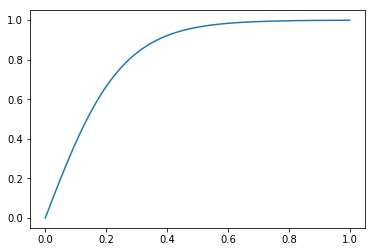

In [592]:
x = np.linspace(0,1,100)
t=4
y=np.tanh(t*x)
plt.plot(x,y)